In [2]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
import community
import itertools
from ast import literal_eval
import matplotlib.pyplot as plt
%matplotlib inline


In [ ]:
team_data = pd.read_csv('LeagueofLegends_Clean.csv',converters={"bKills": literal_eval, "rKills": literal_eval, 
                                                          "goldblue": literal_eval, 
                                                          "goldred": literal_eval})

In [174]:
teams_blue = team_data[['League','Year','Season','Type','blueTeamTag','bResult','redTeamTag','gamelength', 'goldblue', 'bKills',
                       'blueTop','blueJungle','blueMiddle', 'blueADC', 'blueSupport']]
teams_red = team_data[['League','Year','Season','Type','redTeamTag','rResult','blueTeamTag','gamelength', 'goldred', 'rKills',
                      'redTop','redJungle','redMiddle', 'redADC', 'redSupport']]

teams_blue.columns = ['League','Year','Season','Type','Team','Win', 'Opponent', 'Length', 'Gold', 'Kills',
                      'Top','Jungle','Middle', 'ADC', 'Support']
teams_red.columns = ['League','Year','Season','Type','Team','Win', 'Opponent', 'Length', 'Gold', 'Kills',
                     'Top','Jungle','Middle', 'ADC', 'Support']

teams = pd.concat([teams_blue, teams_red])
teams = teams.dropna()
teams = teams.reset_index(drop=True)

# Borramos los espacios tontos

teams['Top'] = teams['Top'].map(lambda x: x.strip())
teams['Jungle'] = teams['Jungle'].map(lambda x: x.strip())
teams['Middle'] = teams['Middle'].map(lambda x: x.strip())
teams['ADC'] = teams['ADC'].map(lambda x: x.strip())
teams['Support'] = teams['Support'].map(lambda x: x.strip())

teams.shape

(15164, 15)

In [139]:
teams.index

RangeIndex(start=0, stop=15164, step=1)

In [34]:
# Primero haré los cálculos para todos y luego ya filtro si eso

# teams_eu = teams[(teams['League'] == 'EULCS') & (teams['Type'] != 'Promotion') & (teams['Year'] != 2018)]
# teams_na = teams[(teams['League'] == 'NALCS') & (teams['Type'] != 'Promotion') & (teams['Year'] != 2018)]
# teams_kr = teams[(teams['League'] == 'LCK') & (teams['Type'] != 'Promotion') & (teams['Year'] != 2018)]

In [35]:
# teams_eu.shape

(1882, 10)

In [55]:
teams.iloc[0]['Gold'][-1]/teams.iloc[0]['Length']

1568.2249999999999

In [39]:
# print(len(teams_eu['Team'].unique()))
# print(len(teams_na['Team'].unique()))
# print(len(teams_kr['Team'].unique()))

18
20
24


# CÁLCULOS

Empezamos haciéndolo en general en Teams. Se trata de obtener las redes en cada caso y calcular:
- Suma Weighted IN-DEGREE
- Suma Weighted OUT-DEGREE
- Num kills
- Suma de degrees dividido por dos y por numero de kills (así, se tiene assists entre kills).
- Weight centralization
- in-strength centralization
- out-strength centralization

- Gold per minute (gold[-1]/Length) as performance


In [47]:
assist_graph = nx.DiGraph()

assist_graph.add_node(teams.iloc[0]['Team'] + ' ' + teams.iloc[0]['Top'])
assist_graph.add_node(teams.iloc[0]['Team'] + ' ' + teams.iloc[0]['Jungle'])
assist_graph.add_node(teams.iloc[0]['Team'] + ' ' + teams.iloc[0]['Middle'])
assist_graph.add_node(teams.iloc[0]['Team'] + ' ' + teams.iloc[0]['ADC'])
assist_graph.add_node(teams.iloc[0]['Team'] + ' ' + teams.iloc[0]['Support'])

assist_graph.nodes()
for kill in teams.iloc[0]['Kills']:
    killer = kill[2]

    for assistant in kill[3]:

        if assist_graph.has_edge(assistant,killer):
            assist_graph[assistant][killer]['weight'] += 1 
        else:
            assist_graph.add_edge(assistant, killer, weight = 1)

OutEdgeDataView([('TSM Dyrus', 'TSM Bjergsen', {'weight': 5}), ('TSM Dyrus', 'TSM WildTurtle', {'weight': 3}), ('TSM Santorin', 'TSM WildTurtle', {'weight': 5}), ('TSM Santorin', 'TSM Bjergsen', {'weight': 7}), ('TSM Santorin', 'TSM Dyrus', {'weight': 1}), ('TSM Bjergsen', 'TSM WildTurtle', {'weight': 5}), ('TSM Bjergsen', 'TSM Dyrus', {'weight': 2}), ('TSM Bjergsen', 'TSM Santorin', {'weight': 1}), ('TSM WildTurtle', 'TSM Bjergsen', {'weight': 7}), ('TSM WildTurtle', 'TSM Dyrus', {'weight': 2}), ('TSM WildTurtle', 'TSM Santorin', {'weight': 1}), ('TSM Lustboy', 'TSM WildTurtle', {'weight': 5}), ('TSM Lustboy', 'TSM Bjergsen', {'weight': 7}), ('TSM Lustboy', 'TSM Dyrus', {'weight': 2}), ('TSM Lustboy', 'TSM Santorin', {'weight': 1})])

In [50]:
assist_graph.nodes()

NodeView(('TSM Dyrus', 'TSM Santorin', 'TSM Bjergsen', 'TSM WildTurtle', 'TSM Lustboy'))

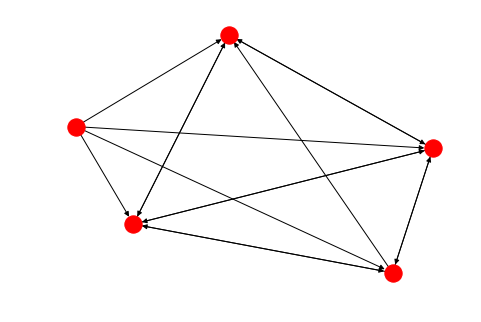

In [52]:
plt.figure(1)
nx.draw(assist_graph, pos=nx.spring_layout(assist_graph))
plt.show()

In [175]:
i= 0

assist_graph = nx.DiGraph()

sum_w_id = []
sum_w_od = []

id_list = []
od_list = []

num_kills = []

intensity = []

ci = []
co = []
cw = []

assists = []
gold_min = []

for index, row in teams.iterrows():
    num_kills.append(len(row['Kills']))
    
    assist_graph = nx.DiGraph()
    assist_graph.add_node(row['Team'] + ' ' + row['Top'])
    assist_graph.add_node(row['Team'] + ' ' + row['Jungle'])
    assist_graph.add_node(row['Team'] + ' ' + row['Middle'])
    assist_graph.add_node(row['Team'] + ' ' + row['ADC'])
    assist_graph.add_node(row['Team'] + ' ' + row['Support'])
    
    if len(assist_graph.nodes()) != 5:
        print(index)
        
    
    ############################## AFEGIR EL CAS NO KILLS ######################
    
    for kill in row['Kills']:
        # GRAFO
        killer = kill[2].strip()
        # Ojo con los TOO EARLY que se cuelan
        if killer != 'TooEarly':
            for assistant in kill[3]:
                assistant = assistant.strip()
                if assist_graph.has_edge(assistant,killer):
                    assist_graph[assistant][killer]['weight'] += 1 
                else:
                    assist_graph.add_edge(assistant, killer, weight = 1)

    # Ahora tenemos el grafo construido

    assistencias = []
    for u,v,w in list(assist_graph.edges(data = True)):
        assistencias.append(list(w.values())[0])

    assists.append(sum(assistencias))
    # Calculo indegrees y outdegrees

    indegree = []
    outdegree = []
    
    if len(list(assist_graph.in_degree(weight = 'weight')))>5:
        print(index)
        print(list(assist_graph.in_degree(weight = 'weight')))
    
    for u, v in list(assist_graph.in_degree(weight = 'weight')):
        indegree.append(v)

    for u, v in list(assist_graph.out_degree(weight = 'weight')):
        outdegree.append(v)

    sum_w_id.append(sum(indegree))
    sum_w_od.append(sum(outdegree))
    id_list.append(indegree)
    od_list.append(outdegree)

    # Calculo strength centralization

    if sum(indegree) == 0:
        ci.append(0)
    else:
        total = 0
        for n in indegree:
            total = total + (max(indegree) - n)
        ci.append(total/4/sum(assistencias))

    if sum(outdegree) == 0:
        co.append(0)
    else:
        total = 0
        for n in outdegree:
            total = total + (max(outdegree) - n)
        co.append(total/4/sum(assistencias))

    # Calculo weight centralization

    assist_graph.add_edges_from(nx.non_edges(assist_graph), weight = 0)

    weight_list = []
    for u,v,w in list(assist_graph.edges(data = True)):
        weight_list.append(list(w.values())[0])

    if sum(weight_list) == 0:
        cw.append(0)
    else:
        cw_total = 0
        max_w = max(weight_list)
        for n in weight_list:
            cw_total = cw_total + (max_w - n)
        cw.append(cw_total/19/sum(assistencias))

    if len(row['Kills']) != 0:
        intensity.append(sum(assistencias)/len(row['Kills']))
    else:
        intensity.append(0)

    # Gold por min
    gold_min.append(row['Gold'][-1]/row['Length'])
    #else:
    #    i = i+1
    #    sum_w_id.append(0)
    #    sum_w_od.append(0)

    #    id_list.append(0)
    #    od_list.append(0)

    #    intensity.append(0)

    #    ci.append(0)
    #    co.append(0)
    #    cw.append(0)

    #    assists.append(0)
    #    print(index)
    #    print(0)
    #    gold_min.append(row['Gold'][-1]/row['Length'])

In [176]:
#sum_w_id_s = pd.Series(sum_w_id)
#sum_w_od_s = pd.Series(sum_w_od)

id_list_s = pd.Series(id_list)
od_list_s = pd.Series(od_list)

assists_s = pd.Series(assists)
num_kills_s = pd.Series(num_kills)
intensity_s = pd.Series(intensity)
ci_s = pd.Series(ci)
co_s = pd.Series(co)
cw_s = pd.Series(cw)
gold_min_s = pd.Series(gold_min)


In [177]:
teams['Assists'] = assists_s
#teams['IN_W'] = sum_w_id_s
#teams['OUT_W'] = sum_w_od_s
teams['In_list'] = id_list_s
teams['Out_list'] = od_list_s
teams['N_Kills'] = num_kills_s
teams['Intensity'] = intensity_s
teams['CI'] = ci_s.values
teams['CO'] = co_s.values
teams['CW'] = cw_s.values
teams['Gold_per_min'] = gold_min_s.values

In [180]:
teams.to_csv('LoL_Network_Structure_Clean.csv')

In [6]:
teams = pd.read_csv('20180315_LoL_Network_Structure_Clean.csv')

In [15]:
teams['A/min'] = teams['Assists']/teams['Length']
teams['K/min'] = teams['N_Kills']/teams['Length']

In [16]:
teams.describe()

,Year,Win,Length,Assists,N_Kills,Intensity,CI,CO,CW,Gold_per_min,Assists_per_min,Kills_per_min,A/min,K/min
count,15164.000000,15164.000000,15164.000000,15164.000000,15164.000000,15164.000000,15164.000000,15164.000000,15164.000000,15164.000000,15164.000000,15164.000000,15164.000000,15164.000000
mean,2016.282511,0.500000,37.009101,29.898839,12.533632,2.330520,0.350701,0.140240,0.130773,1684.700608,0.815527,0.345126,0.815527,0.345126
std,0.849940,0.500016,7.986290,17.909982,6.937249,0.589045,0.195785,0.102525,0.101264,192.299289,0.496387,0.201922,0.496387,0.201922
min,2014.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1083.708333,0.000000,0.000000,0.000000,0.000000
25%,2016.000000,0.000000,31.000000,15.000000,7.000000,2.000000,0.218750,0.085366,0.078947,1533.164395,0.416667,0.191489,0.416667,0.191489
50%,2016.000000,0.500000,36.000000,29.000000,12.000000,2.363636,0.308036,0.120370,0.106858,1695.441157,0.756757,0.317073,0.756757,0.317073
75%,2017.000000,1.000000,41.000000,42.000000,17.000000,2.719063,0.431818,0.166667,0.151104,1842.195503,1.146341,0.468085,1.146341,0.468085
max,2018.000000,1.000000,95.000000,124.000000,71.000000,4.000000,1.000000,1.000000,1.000000,2310.026316,3.571429,1.868421,3.571429,1.868421


In [276]:
teams['N_Kills'].sum()

190060

In [277]:
teams['Assists'].sum()

453386

In [278]:
teams['Assists'].sum()/teams['N_Kills'].sum()

2.3854887930127329

In [256]:
len(teams['Team'].unique())

244

In [281]:
teams[teams['N_Kills'] == 0].count()/15164

League          0.007452
Year            0.007452
Season          0.007452
Type            0.007452
Team            0.007452
Win             0.007452
Opponent        0.007452
Length          0.007452
Gold            0.007452
Kills           0.007452
Top             0.007452
Jungle          0.007452
Middle          0.007452
ADC             0.007452
Support         0.007452
Assists         0.007452
In_list         0.007452
Out_list        0.007452
N_Kills         0.007452
Intensity       0.007452
CI              0.007452
CO              0.007452
CW              0.007452
Gold_per_min    0.007452
dtype: float64

In [266]:
teams['Year'].unique()

array([2015, 2016, 2017, 2014, 2018], dtype=int64)

In [270]:
teams.groupby('Year').size().nlargest(5)

Year
2017    6622
2016    4914
2015    2990
2018     482
2014     156
dtype: int64

In [274]:
teams.groupby('Team').size().nsmallest(5)

Team
as      1
CF      2
CLB     2
Crew    2
DH      2
dtype: int64

In [17]:
all_features = ['A/min', 'K/min', 'Intensity', 'CI', 'CO', 'CW', 'Gold_per_min']
features = ['A/min', 'K/min', 'Intensity', 'CI', 'CO', 'CW']
target = 'Gold_per_min'
teams_num = teams[features]

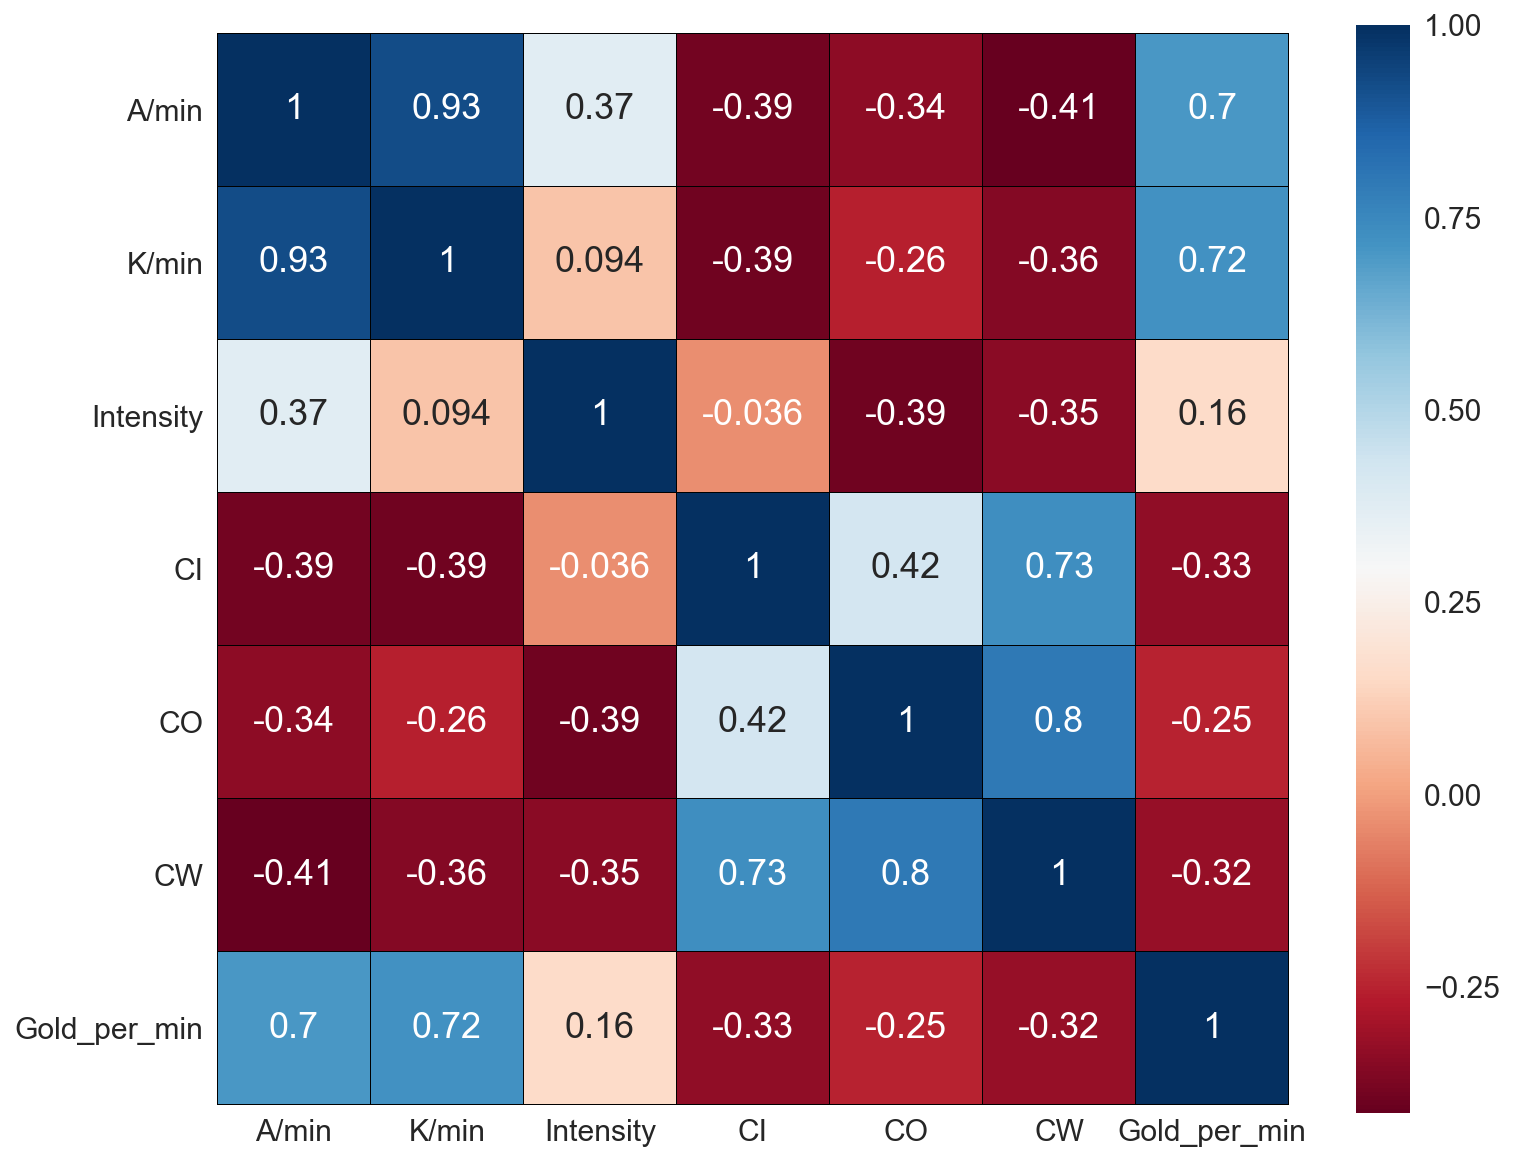

In [18]:
import matplotlib.pyplot as plt # Python defacto plotting library
import seaborn as sns # More snazzy plotting library
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))
plt.title('')
# Draw the heatmap using seaborn
sns.set(font_scale = 1.5)
sns.heatmap(teams[all_features].corr(),linewidths=0.25,vmax=1.0, square=True, cmap="RdBu", linecolor='black', annot=True)

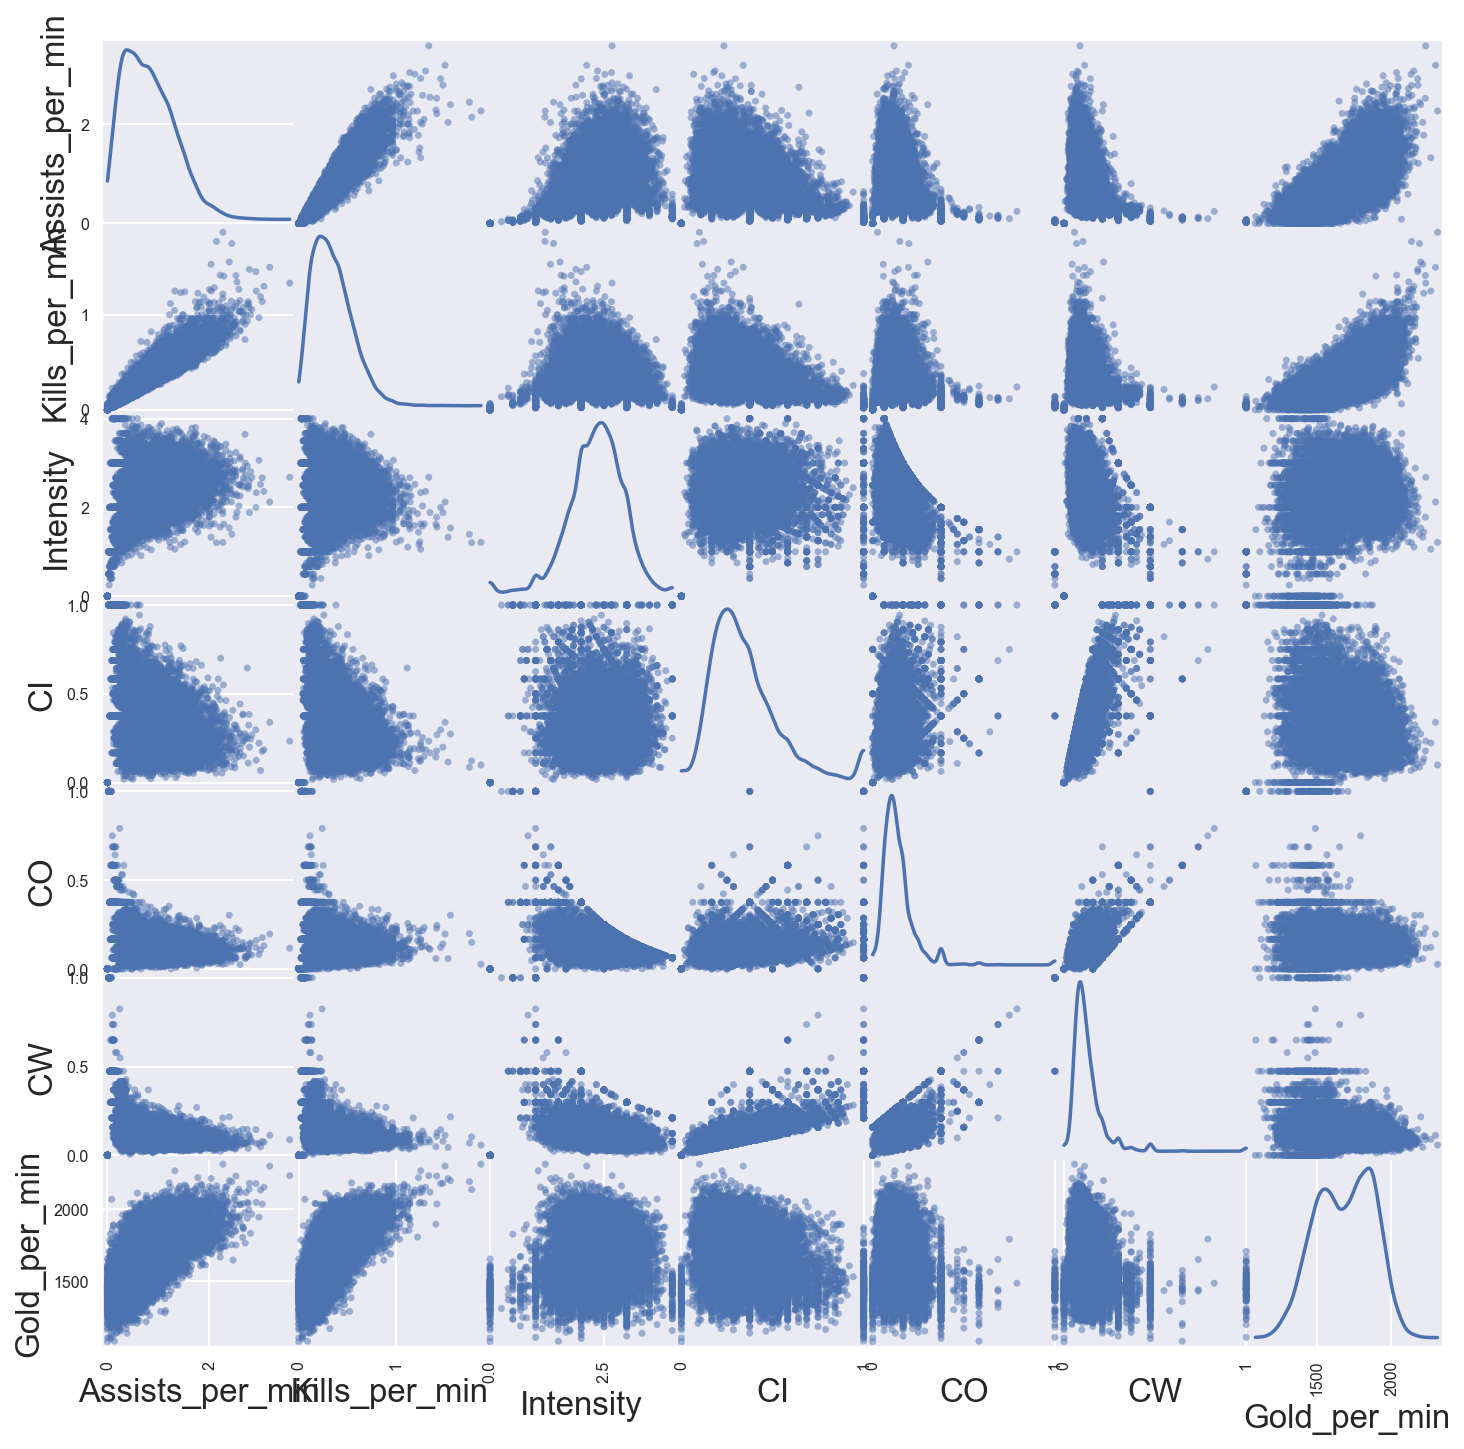

In [12]:
from pandas.plotting import scatter_matrix

scatter_matrix(teams[all_features], figsize = (12, 12), diagonal = 'kde');

# A ver los CARRY

(array([  138.,  1985.,  8226.,  4533.,   282.]),
 array([0, 1, 2, 3, 4, 5]),
 <a list of 5 Patch objects>)

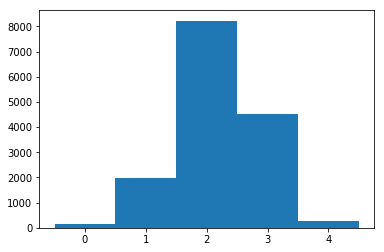

In [195]:
n = []
for index, row in teams.iterrows():
    carry = 0
    if row['Assists'] > 0:
        for player in row['In_list']:
            if player/row['Assists'] >= 0.2:
                carry = carry + 1
    n.append(carry)
plt.hist(n, bins = [0, 1, 2, 3, 4, 5], align='left')            

(array([  138.,  1985.,  8226.,  4533.,   282.]),
 array([0, 1, 2, 3, 4, 5]),
 <a list of 5 Patch objects>)

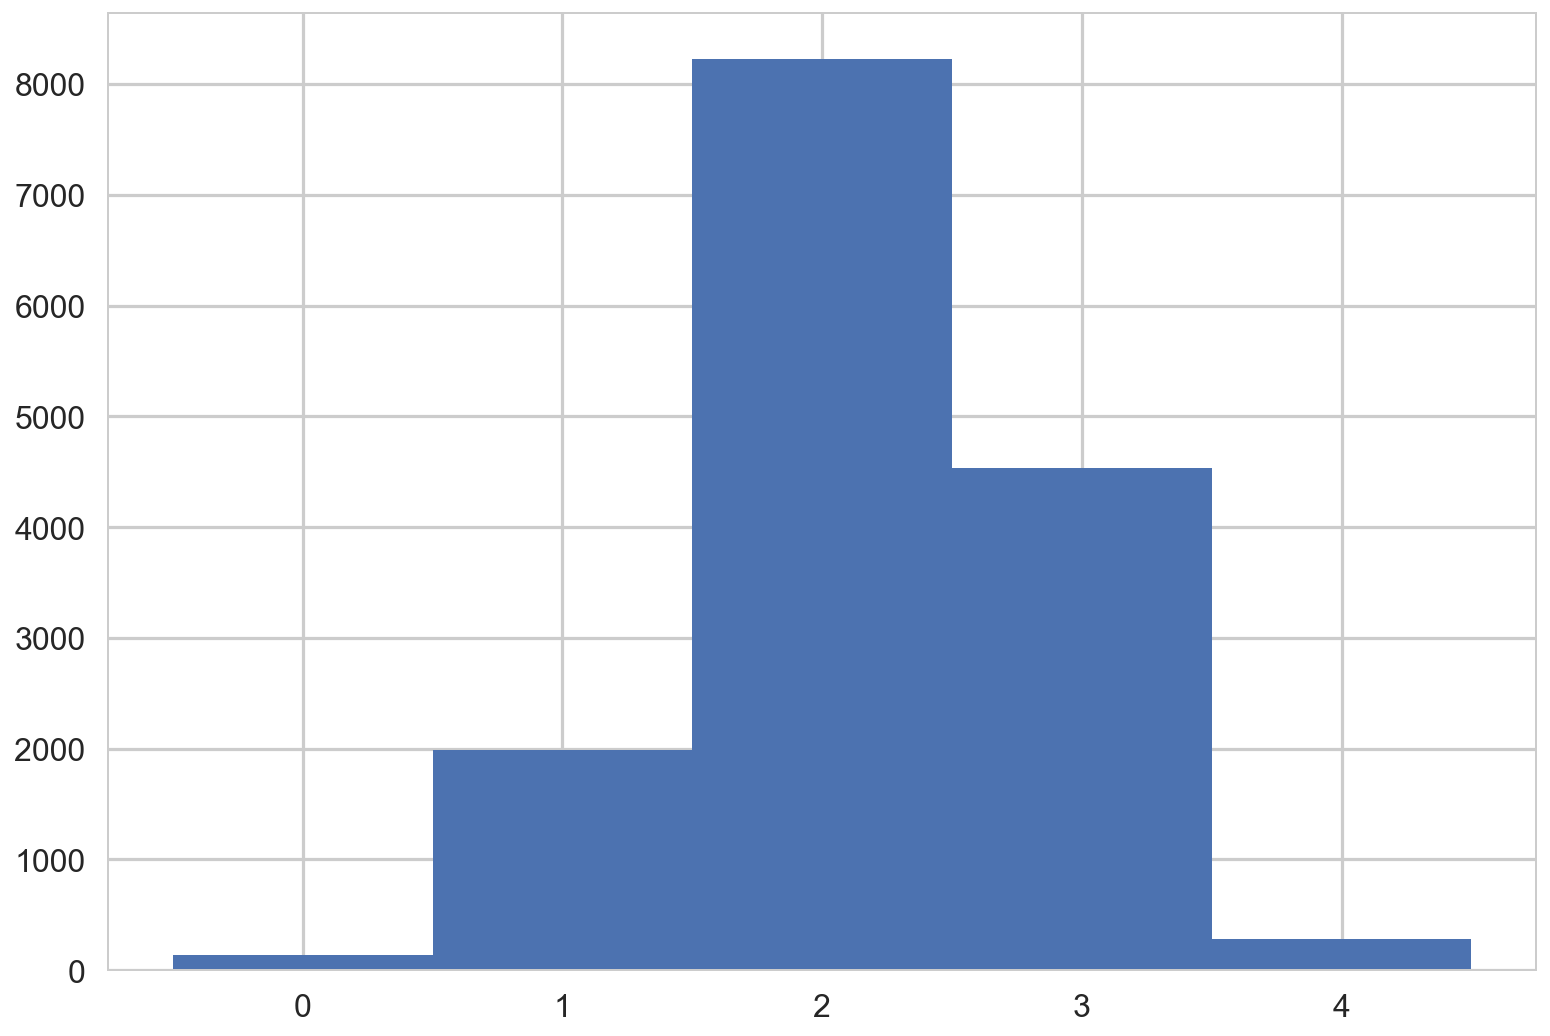

In [247]:
plt.hist(n, bins = [0, 1, 2, 3, 4, 5], align='left')  

# VIF

In [13]:
from sklearn.linear_model import LinearRegression

def calculateVIF(data):
    features = list(data.columns)
    num_features = len(features)
    
    model = LinearRegression()
    
    result = pd.DataFrame(index = ['VIF'], columns = features)
    result = result.fillna(0)
    
    for ite in range(num_features):
        x_features = features[:]
        y_featue = features[ite]
        x_features.remove(y_featue)
        
        x = data[x_features]
        y = data[y_featue]
        
        model.fit(data[x_features], data[y_featue])
        
        result[y_featue] = 1/(1 - model.score(data[x_features], data[y_featue]))
    
    return result

teams_vif = teams.copy(deep = True)

calculateVIF(teams_vif[features])

,Assists_per_min,Kills_per_min,Intensity,CI,CO,CW
VIF,18.036867,15.590121,2.972236,3.08227,3.373165,6.503301


In [14]:
def selectDataUsingVIF(data, max_VIF = 5):
    result = data.copy(deep = True)
    
    VIF = calculateVIF(result)
    print(VIF)
    while VIF.as_matrix().max() > max_VIF:
        col_max = np.where(VIF == VIF.as_matrix().max())[1][0]
        features = list(result.columns)
        print(features[col_max])
        features.remove(features[col_max])
        result = result[features]
        
        VIF = calculateVIF(result)
        print(VIF)
    return result

calculateVIF(selectDataUsingVIF(teams_vif[features]))

     Assists_per_min  Kills_per_min  Intensity       CI        CO        CW
VIF        18.036867      15.590121   2.972236  3.08227  3.373165  6.503301
Assists_per_min
     Kills_per_min  Intensity        CI        CO        CW
VIF       1.201411   1.298388  2.978918  3.361728  6.371916
CW
     Kills_per_min  Intensity        CI        CO
VIF       1.201026   1.214482  1.398791  1.484282


,Kills_per_min,Intensity,CI,CO
VIF,1.201026,1.214482,1.398791,1.484282


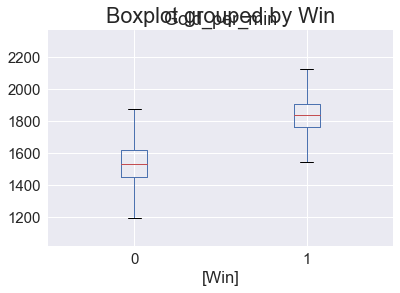

In [226]:
teams.boxplot(column=['Gold_per_min'], by=['Win'])

[Text(0,0.5,'Gold per minute'), Text(0.5,0,'Win')]

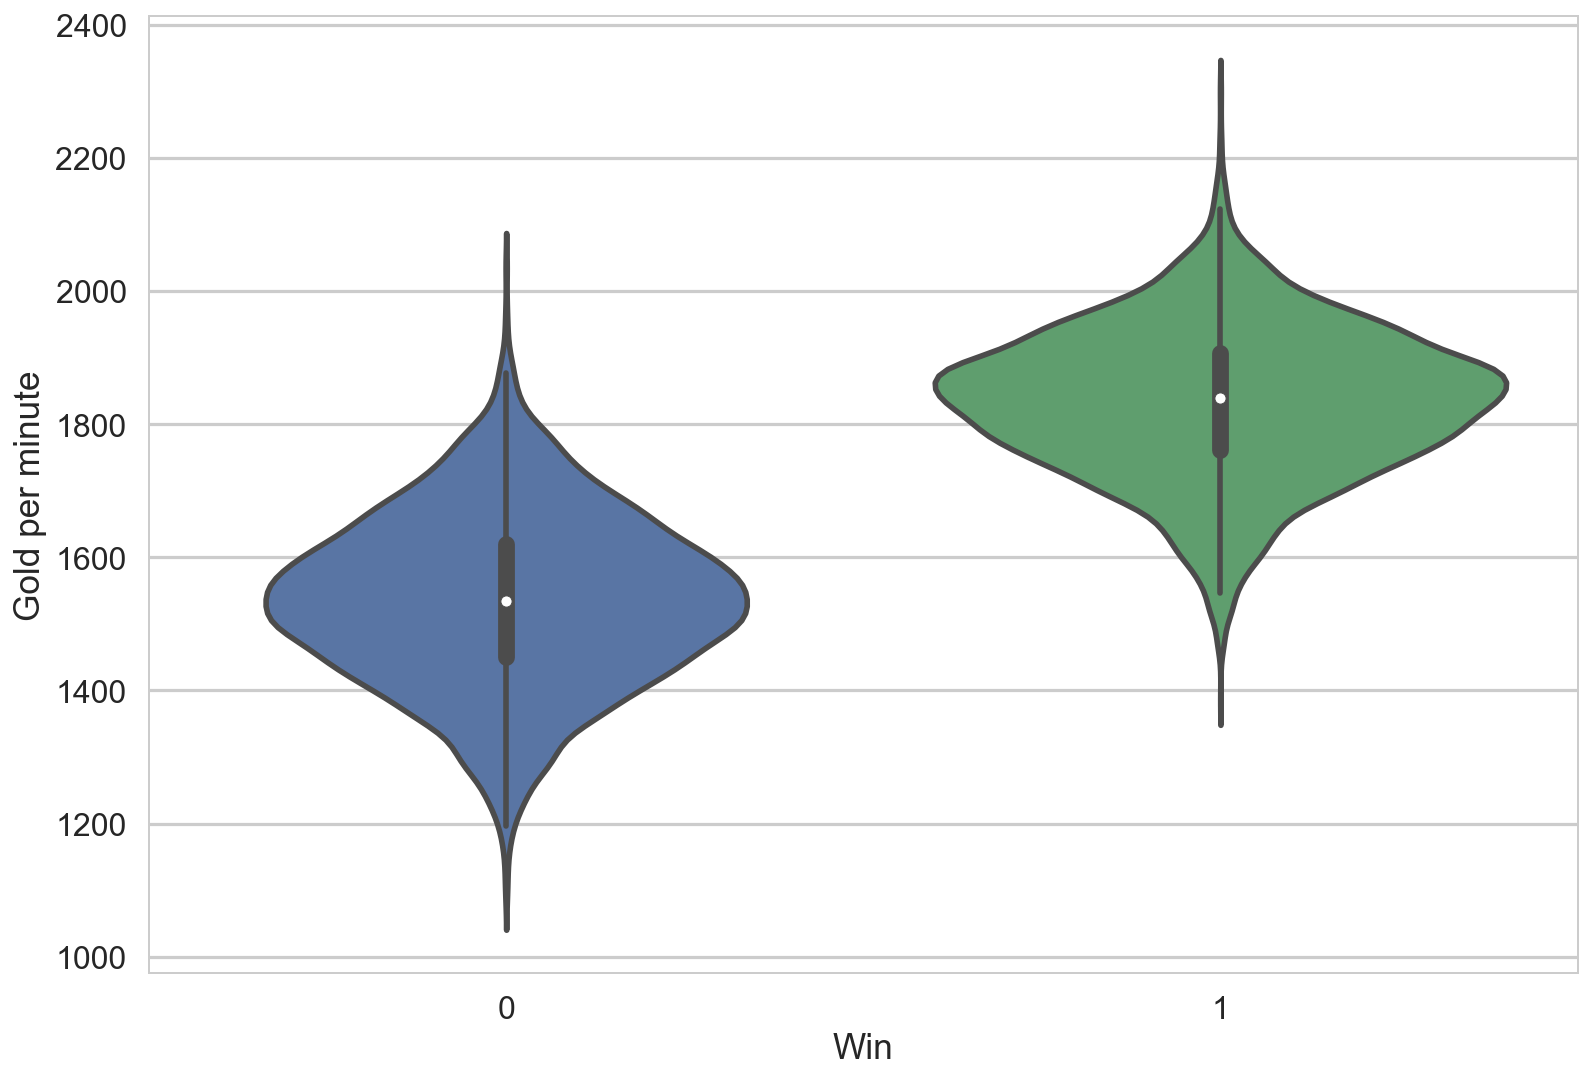

In [246]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_style("whitegrid")
plt.style.use('seaborn-poster')
ax = sns.violinplot(x='Win', y='Gold_per_min', data=teams)
ax.set(xlabel='Win', ylabel='Gold per minute')
